# Práctica 6

date: 07/11/2023  
File: Chehade_practica6.ipynb
Author : Pablo Naim Chehade   
Email: pablo.chehade.villalba@gmail.com  
GitHub: https://github.com/Lupama2  

In [9]:
#Import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#Hago los gráficos interactivos
%matplotlib ipympl

#Fuente y tamaño de los caracteres en los gráficos
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 17}
matplotlib.rc('font', **font)


## Ejercicio 1

In [10]:
alpha_vec = np.array([0.12, 0.14, 0.16, 0.18])
N_vec = np.array([500, 1000, 2000, 4000])
# N_vec = np.array([50, 100, 200, 400])
alpha = alpha_vec[0] #valor típico a usar en las simulaciones
N = N_vec[0] #valor típico a usar en las simulaciones

#Calculo p
p = int(alpha*N)
print(f"p = {p}")

def gen_patrones(p, N):
    #Se generan p patrones de N elementos. Se retornan como una matriz
    return np.random.randint(0,2, size = (p, N))*2 - 1

p = 60


In [11]:
#Calculo la matriz de conexiones

def matriz_conexiones(x):
    #x: patrones

    #Menos eficiente:
    W = np.zeros((N,N))
    #Calculo el producto externo
    for mu in range(p):
        W += np.outer(x[mu], x[mu])
    #Se eliminan las conexiones de la neurona consigo misma
    W -= np.diag(np.diag(W))

    #De forma más eficiente:
    # W = np.einsum('...i,...j->...ij', x, x).sum(axis=0)
    # np.fill_diagonal(W, 0)

    return W/x.shape[1]

# matriz_conexiones(gen_patrones(5, 5))

In [12]:
def iter_secuencial_determinista(S_t, W, T = 0):
    #Calcula S(t+1) dado S(t) de forma secuencial
    for i in range(N):
        S_t[i] = np.sign(np.dot(W[i], S_t))

    return S_t

def iter_paralelo_determinista(S_t, W, T = 0):
    #Calcula S(t+1) dado S(t) de forma paralela
    S_t = np.sign(np.dot(W, S_t))

    return S_t

#Def la función de Lyapunov
def E_Lyapunov(S, W):
    #S: configuración de la red

    return -1/2*np.sum(W*np.outer(S, S))

def overlap_determinista(S_matrix, x):
    #Calcula el overlap entre s y x
    return np.dot(S_matrix[-1], x)/N


In [13]:
def evolution(p, N, iter_, overlap, T = 0, N_iter = 10, calculate_all = False):
    #iter_: función que calcula la dinámica de la red. Como input tiene S(t) y W
    #overlap: función que calcula el overlap entre S(t_final) y x
    #calculate_all indica si se calcula el error y delta_S

    x = gen_patrones(p, N)
    W = matriz_conexiones(x)

    overlap_vec = np.empty(p)
    f_conv_vec = np.empty(p)

    if calculate_all:
        error_matrix = np.empty([p, N_iter])
        delta_S_matrix = np.empty([p, N_iter - 1])
        

    for mu in range(p):

        S_matrix = np.empty([N_iter, N])
        S_matrix[0] = x[mu]

        for t in range(1, N_iter):
            S_matrix[t] = iter_(S_matrix[t-1], W, T)

        f_conv_vec[mu] = np.all(S_matrix[-2] - S_matrix[-1] == 0) #fracción de simulaciones que convergieron
        overlap_vec[mu] = overlap(S_matrix, x[mu])
        #Control
        # if overlap_vec[mu] < 0 or overlap_vec[mu] > 1:
            # raise ValueError(f"El overlap es {overlap_vec[mu]}")

        if calculate_all:
            delta_S_array = np.mean(np.abs(S_matrix[1:] - S_matrix[:-1]), axis = 1)
            delta_S_matrix[mu] = delta_S_array
            error_array = np.mean(np.abs(S_matrix - S_matrix[0])**2, axis = 1)
            error_matrix[mu] = error_array

    if calculate_all:
        #Calculo el valor medio del error
        delta_S_medio = np.mean(delta_S_matrix, axis = 0)
        delta_S_std = np.std(delta_S_matrix, axis = 0)/np.sqrt(p) #desviación estándard de la media
        error_medio = np.mean(error_matrix, axis = 0)
        error_std = np.std(error_matrix, axis = 0)/np.sqrt(p) #desviación estándard de la media

    #Calculo cuántas veces convergió
    #es decir, cuantas veces delta_S_matrix[:, -2] - delta_S_matrix[:,-1] == 0


    if calculate_all:
        return delta_S_medio, delta_S_std, error_medio, error_std, overlap_vec, f_conv_vec
    else:
        return overlap_vec, np.mean(f_conv_vec)


In [14]:
N_iter = 20
delta_S_medio_seq, delta_S_std_seq, error_medio_seq, error_std_seq, overlap_vec_seq, f_conv_seq = evolution(p, N, iter_secuencial_determinista, overlap_determinista, N_iter = N_iter, calculate_all=True)
delta_S_medio_par, delta_S_std_par, error_medio_par, error_std_par, overlap_vec_par, f_conv_par = evolution(p, N, iter_secuencial_determinista, overlap_determinista, N_iter = N_iter, calculate_all=True)

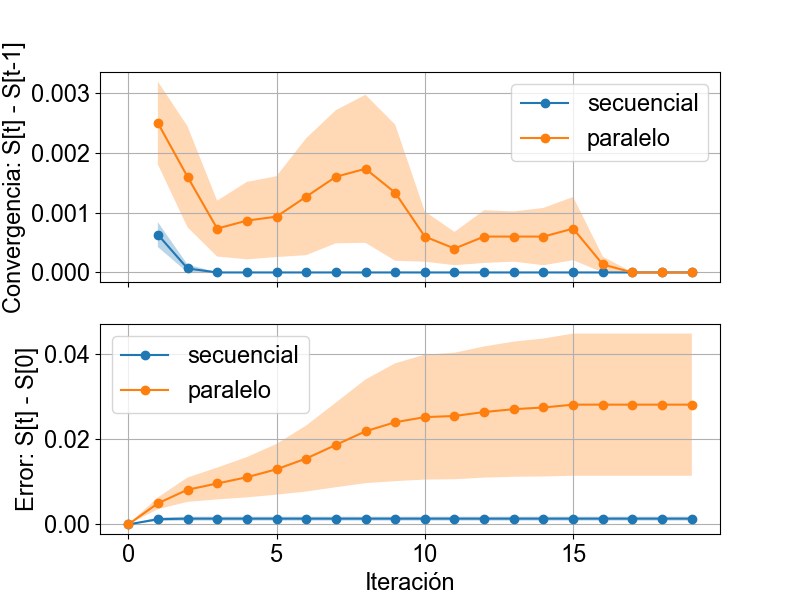

In [15]:
#Grafico delta_S_medio y error_medio
fig, ax = plt.subplots(2,1, figsize = (8,6), sharex=True)

#Grafuco delta_S_medio con error
ax[0].plot(np.arange(1, N_iter), delta_S_medio_seq, "o-", label = 'secuencial')
ax[0].fill_between(np.arange(1, N_iter), delta_S_medio_seq - delta_S_std_seq, delta_S_medio_seq + delta_S_std_seq, alpha = 0.3)
ax[0].plot(np.arange(1, N_iter), delta_S_medio_par, "o-", label = 'paralelo')
ax[0].fill_between(np.arange(1, N_iter), delta_S_medio_par - delta_S_std_par, delta_S_medio_par + delta_S_std_par, alpha = 0.3)

ax[0].set_ylabel('Convergencia: S[t] - S[t-1]')
ax[0].legend()
ax[0].grid()


ax[1].plot(np.arange(0, N_iter), error_medio_seq, "o-", label = 'secuencial')
ax[1].fill_between(np.arange(0, N_iter), error_medio_seq - error_std_seq, error_medio_seq + error_std_seq, alpha = 0.3)
ax[1].plot(np.arange(0, N_iter), error_medio_par, "o-", label = 'paralelo')
ax[1].fill_between(np.arange(0, N_iter), error_medio_par - error_std_par, error_medio_par + error_std_par, alpha = 0.3)

ax[1].set_ylabel('Error: S[t] - S[0]')
ax[1].set_xlabel('Iteración')
ax[1].legend()
# ax.set_yscale("log")
ax[1].grid()


plt.show()


In [16]:
#Recorro N_vec y alpha_vec, calculo para cada caso f_conv y luego imprimo todos los valores en una tabla

N_iter = 20

f_conv_seq_matrix = np.empty([len(N_vec), len(alpha_vec)])
f_conv_par_matrix = np.empty([len(N_vec), len(alpha_vec)])

for i in range(len(N_vec)):
    for j in range(len(alpha_vec)):
        N = N_vec[i]
        alpha = alpha_vec[j]
        p = int(alpha*N)

        # overlap_vec_seq, f_conv_seq_matrix[i,j] = evolution(p, N, iter_secuencial_determinista, overlap_determinista, N_iter = N_iter, calculate_all=False)
        overlap_vec_par, f_conv_par_matrix[i,j] = evolution(p, N, iter_secuencial_determinista, overlap_determinista, N_iter = N_iter, calculate_all=False)
        
        #Guardo datos
        # np.save(f'resultados/ej1_overlap_vec_seq_{i}{j}', overlap_vec_seq)


# np.save('resultados/ej1_f_conv_seq_matrix', f_conv_seq_matrix)
np.save('resultados/ej1_f_conv_par_matrix', f_conv_par_matrix)
   


KeyboardInterrupt: 

In [ ]:
error

## Ejercicio 2

In [ ]:
import random

def iter_secuencial_estocastico(S_t, W, T):
    #Calcula S(t+1) dado S(t) de forma secuencial

    #Calculo beta
    beta = 1/T

    for i in range(N):
        #Calculo h_i
        h_i = np.dot(W[i], S_t)
        #Tiro un número aleatorio
        aleatorio = random.random()
        #Calculo la probabilidad de que S_t[i] = 1
        Pr = np.exp(beta*h_i)/(np.exp(beta*h_i) + np.exp(-beta*h_i))
        if aleatorio < Pr:
            S_t[i] = 1
        else:
            S_t[i] = -1

    return S_t

def overlap_estocastico(S_matrix, x):
    #Calculo el overlap entre <S> y x

    #Calculo <S>
    S_medio = np.mean(S_matrix, axis = 0)

    return np.dot(S_medio, x)/N


In [ ]:
N = 4000
p = 40
T_vec = np.linspace(1.1,2,20)

overlap_mean_vec = np.empty(len(T_vec))

for i in tqdm(range(len(T_vec))):
    T = T_vec[i]
    overlap_vec, f_conv = evolution(p, N, iter_secuencial_estocastico, overlap_estocastico, T = T, N_iter = 10, calculate_all = False)
    overlap_mean_vec[i] = np.mean(overlap_vec)

#Guardo datos
np.save('resultados/ej2_T_vec', T_vec)
np.save('resultados/ej2_overlap_mean_vec', overlap_mean_vec)


  0%|          | 0/21 [00:00<?, ?it/s]

C:\Users\lupam\AppData\Local\Temp\ipykernel_10252\2609364361.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  beta = 1/T
C:\Users\lupam\AppData\Local\Temp\ipykernel_10252\2609364361.py:15: RuntimeWarning: invalid value encountered in scalar divide
  Pr = np.exp(beta*h_i)/(np.exp(beta*h_i) + np.exp(-beta*h_i))


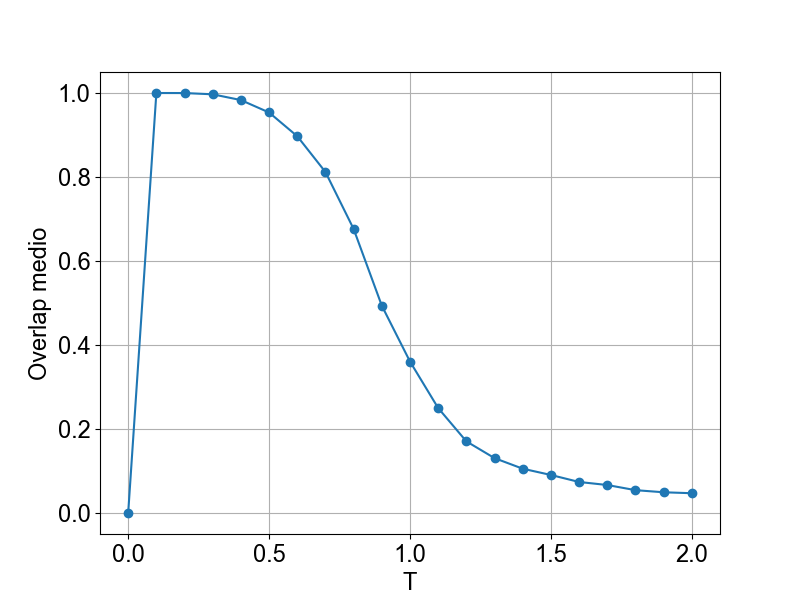